# Прогноз спроса на товары

**Данные:** история за 2 года, продажи, спрос и так далее.

**Модель:** базовые мл модели: линейные + деревья

**Метрики:** RMSE, MAE, R2  

**Цель**: получить модель готовую к реальному использованию (SOTA)






### Почему это важно?
Точный прогноз спроса помогает:
- Оптимизировать запасы и снижать издержки на хранение  
- Планировать производство и логистику  
- Минимизировать дефицит и избыточные закупки  
- Повышать прибыльность бизнеса за счёт корректного планирования

# Проверяем данные на наличие проблем. Смотрим распределение величин.

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv("/kaggle/input/retail-sales-forecasting/mock_kaggle.csv")

In [ ]:
df.columns

Index(['data', 'venda', 'estoque', 'preco'], dtype='object')

In [ ]:

# Переименование колонок
df = df.rename(columns={
    'data': 'date',
    'venda': 'sales',
    'estoque': 'stock',
    'preco': 'price'
})


In [ ]:
target_column = 'sales'

In [ ]:
import os
import base64
from io import BytesIO
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from IPython.display import display, Markdown
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

def bold(text): return f"**{text}**"
def code(text): return f"`{text}`"

# Объединённая и дополненная версия функции с сохранением графиков и расширенным анализом
def analyze_and_export(df: pd.DataFrame, target_column: str, output_dir: str = "report_output"):
    os.makedirs(output_dir, exist_ok=True)
    report_lines = []

    def fig_to_base64_img_tag():
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        plt.close()
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return f"<img src='data:image/png;base64,{img_base64}' width='800'>"

    report_lines.append("<h1>📊 Анализ набора данных</h1>")





    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

        # 📋 Табличные характеристики признаков
    report_lines.append("<h3>📋 Табличные характеристики признаков</h3>")
    # desc_df = pd.DataFrame({
    #     "Уникальных значений": df.nunique(),
    #     "Тип данных": df.dtypes,
    #     "Минимум": df[numerical_cols].min(),
    #     "Максимум": df[numerical_cols].max(),
    #     "Среднее": df[numerical_cols].mean(),
    #     "Ст. отклонение": df[numerical_cols].std()
    # }).fillna("-")
    # report_lines.append(desc_df.to_html())

    # report_lines.append(f"<h3>Категориальные признаки:</h3><p>{', '.join(categorical_cols) or 'нет'}</p>")
    # report_lines.append(f"<h3>Числовые признаки:</h3><p>{', '.join(numerical_cols) or 'нет'}</p>")

    # Пропущенные значения
    missing = df.isnull().sum()[df.isnull().sum() > 0]
    report_lines.append("<h3>🔍 Пропущенные значения</h3>")
    if not missing.empty:
        report_lines.append(missing.to_frame("Количество пропусков").to_html())
    else:
        report_lines.append("<p>Нет пропущенных значений.</p>")

    kl_values = []
    for col in df.columns:
        if col == target_column:
            kl_values.append("-")
            continue

        col_values = df[col].dropna()
        if df[col].dtype == 'object' or df[col].nunique() < 20:
            dist = col_values.value_counts(normalize=True)
        else:
            dist, _ = np.histogram(col_values, bins=10, density=True)
            dist = dist / np.sum(dist)

        uniform = np.full_like(dist, 1 / len(dist))
        try:
            kl = entropy(dist, uniform)
            kl_values.append(round(kl, 4))
        except:
            kl_values.append("error")

    desc_df = pd.DataFrame({
        "Уникальных значений": df.nunique(),
        "Тип данных": df.dtypes,
        "Минимум": df.select_dtypes(include=[np.number]).min(),
        "Максимум": df.select_dtypes(include=[np.number]).max(),
        "Среднее": df.select_dtypes(include=[np.number]).mean(),
        "Ст. отклонение": df.select_dtypes(include=[np.number]).std(),
        "KL-дивергенция": kl_values
    }).fillna("-")

    report_lines.append(desc_df.to_html())
    # Распределение категориальных признаков
    report_lines.append("<h3>📋 Распределение категориальных признаков</h3>")
    small_cat_cols = [col for col in categorical_cols if df[col].nunique() < 12]
    large_cat_cols = [col for col in categorical_cols if 12 <= df[col].nunique() <= 25]



    for col in large_cat_cols:

        plt.figure(figsize=(12, 4))
        plt.title(f'Распределение: {col}')
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        report_lines.append(f"<h4>{col}</h4>")
        report_lines.append(fig_to_base64_img_tag())

    for i in range(0, len(small_cat_cols), 2):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        col1 = small_cat_cols[i]
        sns.countplot(data=df, x=col1, order=df[col1].value_counts().index, ax=axes[0])
        axes[0].set_title(f'Распределение: {col1}')
        if i + 1 < len(small_cat_cols):
            col2 = small_cat_cols[i + 1]
            sns.countplot(data=df, x=col2, order=df[col2].value_counts().index, ax=axes[1])
            axes[1].set_title(f'Распределение: {col2}')
        else:
            axes[1].axis('off')
        report_lines.append(fig_to_base64_img_tag())

    # Распределение числовых признаков
    report_lines.append("<h3>📈 Распределение числовых признаков</h3>")
    num_pairs = [(numerical_cols[i], numerical_cols[i + 1] if i + 1 < len(numerical_cols) else None)
                 for i in range(0, len(numerical_cols), 2)]
    for col1, col2 in num_pairs:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if df[col1].dropna().nunique() < 20 and pd.api.types.is_integer_dtype(df[col1]):
            sns.countplot(x=col1, data=df, ax=axes[0])
        else:
            sns.histplot(df[col1].dropna(), kde=True, ax=axes[0])
        axes[0].set_title(f'Распределение: {col1}')

        if col2:
            if df[col2].dropna().nunique() < 20 and pd.api.types.is_integer_dtype(df[col2]):
                sns.countplot(x=col2, data=df, ax=axes[1])
            else:
                sns.histplot(df[col2].dropna(), kde=True, ax=axes[1])
            axes[1].set_title(f'Распределение: {col2}')
        else:
            axes[1].axis('off')

        report_lines.append(fig_to_base64_img_tag())



    # 📊 Матрица корреляции
    report_lines.append("<h3>📊 Матрица корреляции числовых признаков</h3>")
    plt.figure(figsize=(10, 8))
    corr = df[numerical_cols + [target_column]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    report_lines.append(fig_to_base64_img_tag())

    report_lines.append("<h3>📊 Распределение целевой переменной </h3>")

    if df[target_column].dtypes in ['object', 'category']:
        plt.figure(figsize=(12, 4))
        plt.title(f'Распределение: {col}')
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        report_lines.append(f"<h4>{col}</h4>")
        report_lines.append(fig_to_base64_img_tag())
    else:
        plt.figure(figsize=(12, 4))
        if df[target_column].dropna().nunique() < 20 and pd.api.types.is_integer_dtype(df[target_column]):
            sns.countplot(x=target_column, data=df)
        else:
            sns.histplot(df[target_column].dropna(), kde=True)
        plt.title(f'Распределение: {target_column}')
        report_lines.append(fig_to_base64_img_tag())

    # 📐 KL-дивергенция
    report_lines.append("<h3>📐 KL-дивергенция таргета</h3>")
    target_counts = df[target_column].value_counts(normalize=True)
    uniform = np.full_like(target_counts.values, 1 / len(target_counts))
    kl_div = entropy(target_counts.values, uniform)
    if kl_div < 0.05:
        severity = "❎ Отсутствие дисбаланса"
    elif kl_div < 0.3:
        severity = "⚠️ Средний дисбаланс"
    elif kl_div < 0.7:
        severity = "🚨 Большой дисбаланс"
    else:
        severity = "⛔ Критический дисбаланс"

    report_lines.append(f"<p><b>Значение:</b> {kl_div:.4f}<br><b>Оценка:</b> {severity}</p>")

    # Сохранение HTML
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_path = os.path.join(output_dir, f"full_report_{timestamp}.html")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write("<html><head><meta charset='UTF-8'></head><body>" + "\n".join(report_lines) + "</body></html>")

    return report_path



analyze_and_export(df, target_column, "report_output")

'report_output/full_report_20250706_032038.html'

# Выделим ключевые проблемы

| Признак | Статус                         | Проблемы                                                                 | Рекомендации                                                                                  |
|---------|--------------------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| `date`  | Без изменений                  | ×                                                                         | разложим на удобный для модели вид                                                                                             |
| `price` | Требуется корректировка        | Асимметрия (хвост вправо), слабая корреляция с `sales`                    | `удаление`                              |
| `stock` | Требуется корректировка + проблема | Высокая дисперсия, сильная асимметрия, слабая информативность в сыром виде | `квантильное преобразование + небольшой клиппинг (98%) + маштабирование (нейросети/линейка)`                                           |
| `sales` | Требуется корректировка + проблема | Целевая переменная, дисбаланс, длинный хвост, KL-дивергенция 0.5384       | `log1p + маштабирование (нейросети/линейка)`                            |


## Графики

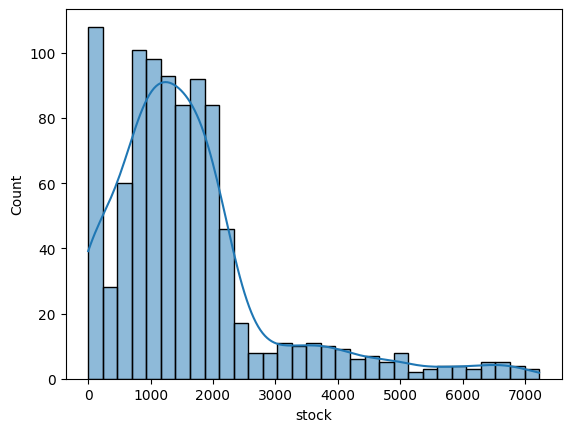

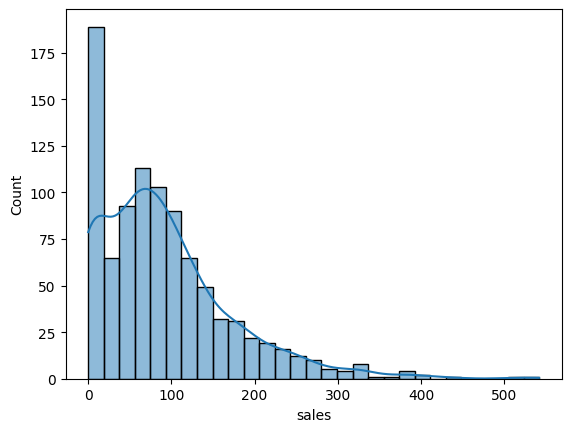

In [ ]:
# пересчитываем kl_divergence

for col in ['stock', 'sales']:
    sns.histplot(df[col].dropna(), kde=True)
    plt.show()

# Работаем с колонкой stock

In [ ]:
from sklearn.preprocessing import QuantileTransformer

df = df.drop('price', axis=1) # слабая корелляция с главной переменной


qt = QuantileTransformer(output_distribution='normal', random_state=0)
df['stock'] = qt.fit_transform(df[['stock']])
lower, upper = df['stock'].quantile([0.01, 0.99])
df['stock'] = df['stock'].clip(lower, upper)



df['sales'] = np.log1p(df['sales'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (937). n_quantiles is set to n_samples.
  warnings.warn(


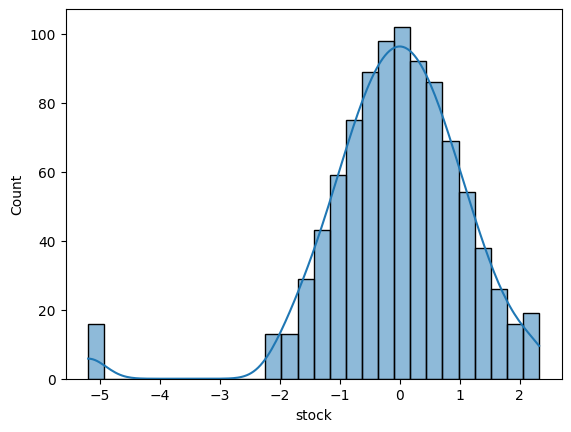

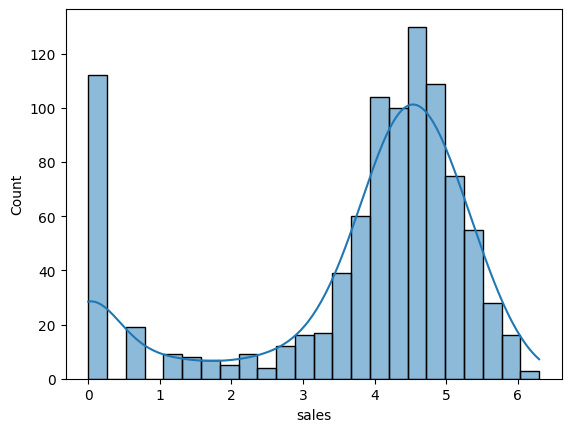

In [ ]:
# пересчитываем kl_divergence

for col in ['stock', 'sales']:
    sns.histplot(df[col].dropna(), kde=True)
    plt.show()

## Вывод: распределение стало лучше, более равномерным.

# Расписываем колонку "дата" на удобный для модели вид, добавляем праздники (для контроля и объяснения вспелсков)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:

df['day']        = df['date'].dt.day             # День месяца (1–31)
df['weekday']    = df['date'].dt.weekday         # День недели (0=Пн, 6=Вс)
df['week']       = df['date'].dt.isocalendar().week  # Номер недели в году
df['month']      = df['date'].dt.month           # Месяц (1–12)
df['year']       = df['date'].dt.year            # Год
df['dayofyear']  = df['date'].dt.dayofyear       # День в году (1–365/366)
df['is_weekend'] = df['weekday'] >= 5            # Признак выходного

In [ ]:
holidays = [
    '01-01',  # Новый год
    '01-07',  # Рождество
    '02-23',  # День защитника Отечества
    '03-08',  # Международный женский день
    '05-01',  # Праздник Весны и Труда
    '05-09',  # День Победы
    '06-12',  # День России
    '11-04',  # День народного единства
]


quarter_start = [f'{m:02d}-01' for m in [1, 4, 7, 10]]
quarter_end   = [f'{m:02d}-31' for m in [3, 6, 9, 12]]  # грубо



df['is_holiday'] = df['date'].dt.strftime('%m-%d').isin(holidays).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['is_year_start'] = df['date'].dt.is_year_start.astype(int)


In [ ]:
df = df.drop('date', axis=1)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import pandas as pd



def find_cor(df, target_column=target_column):
    # X — фичи, y — целевая
    X = df.drop(columns=target_column)
    y = df[target_column]

    # Обработка категориальных признаков
    X_encoded = X.copy()
    for col in X.select_dtypes(include='object'):
        X_encoded[col] = LabelEncoder().fit_transform(X[col])

    # Mutual Info
    mi_scores = mutual_info_regression(X_encoded, y, random_state=0)

    # Красиво выводим
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores
    }).sort_values(by='mutual_info', ascending=False)

    return mi_df



# Доп. Обработка под ml модели

# Добавляем лаги и роллинг лаги. Удаляем те, что меньше коррелирует с главной переменной, как бесполезные. Убираем мультиколленираность.

In [ ]:
columns_for_lags = ['sales', 'stock']

In [ ]:
lags = [1,2,3,4,5,6,7,14,21,28,30]
roling_windows = [3,7,14,21,28,30,45]

df_ext = df.copy()

for col in columns_for_lags:

    for lag in lags:
        df_ext[f'{col}_lag_{lag}'] = df_ext[col].shift(lag)

    # создаём rolling mean
    for window in roling_windows:
        df_ext[f'{col}_roll_mean_{window}'] = df_ext[col].shift(1).rolling(window).mean()

    # удаляем первые строки с NaN (могут появиться из-за shift/rolling)
    df_ext.dropna(inplace=True)

    # считаем корреляцию всех колонок с целевой
    mi_df = find_cor(df_ext)

    # Фильтруем по порогу
    threshold = 0.1
    selected_features = mi_df[mi_df['mutual_info'] >= threshold]['feature'].tolist()
    df_ext = df_ext[selected_features + [target_column]].copy()


In [ ]:
import pandas as pd

# порог корреляции (можно 0.9 или 0.95)
correlation_threshold = 0.9

# копируем только числовые фичи (кроме таргета)
features = df_ext.drop(columns=[target_column])
corr_matrix = features.corr().abs()

# запоминаем пары, у которых корреляция выше порога
high_corr_pairs = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and corr_matrix.loc[col1, col2] > correlation_threshold:
            pair = tuple(sorted([col1, col2]))  # сортируем, чтобы избежать дубликатов
            high_corr_pairs.append(pair)

# удаляем дубликаты
high_corr_pairs = list(set(high_corr_pairs))

# группируем по связанности
from collections import defaultdict

groups = defaultdict(set)
for a, b in high_corr_pairs:
    groups[a].add(a)
    groups[a].add(b)
    groups[b].update(groups[a])
    for var in groups[a]:
        groups[var] = groups[a]

# формируем уникальные группы
unique_groups = set(frozenset(g) for g in groups.values())

# выводим результат
for i, group in enumerate(unique_groups, 1):
    print(f"Группа {i}: {sorted(group)}")


Группа 1: ['sales_lag_2', 'sales_roll_mean_3']
Группа 2: ['sales_roll_mean_21', 'sales_roll_mean_28', 'sales_roll_mean_30', 'sales_roll_mean_45']
Группа 3: ['stock', 'stock_lag_1', 'stock_lag_2', 'stock_lag_3', 'stock_lag_4', 'stock_lag_5', 'stock_lag_6', 'stock_lag_7', 'stock_roll_mean_14', 'stock_roll_mean_21', 'stock_roll_mean_28', 'stock_roll_mean_3', 'stock_roll_mean_30', 'stock_roll_mean_45', 'stock_roll_mean_7']
Группа 4: ['dayofyear', 'month', 'week']
Группа 5: ['sales_roll_mean_14', 'sales_roll_mean_21', 'sales_roll_mean_28', 'sales_roll_mean_30']


In [ ]:
cols_to_drop = [
  'sales_roll_mean_3',
  'sales_roll_mean_28',
  'stock',
  'stock_lag_1',
  'stock_roll_mean_7',
  'stock_roll_mean_28',
  'month'
]




df_ext.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df_ext.columns

Index(['sales_lag_1', 'stock_lag_3', 'stock_lag_2', 'stock_roll_mean_3',
       'sales_lag_2', 'sales_roll_mean_7', 'stock_lag_4', 'stock_lag_5',
       'sales_roll_mean_14', 'dayofyear', 'week', 'sales_lag_3', 'stock_lag_6',
       'stock_roll_mean_30', 'sales_roll_mean_21', 'stock_roll_mean_21',
       'sales_roll_mean_30', 'sales_roll_mean_45', 'stock_lag_7',
       'sales_lag_5', 'stock_roll_mean_14', 'stock_roll_mean_45',
       'sales_lag_7', 'stock_lag_21', 'sales_lag_4', 'sales_lag_6',
       'stock_lag_14', 'sales'],
      dtype='object')

In [ ]:
df_ext['sales'].value_counts()

sales
0.000000    111
0.693147     19
4.143135     15
3.761200     12
4.174387     10
           ... 
5.472271      1
5.564520      1
2.397895      1
2.564949      1
5.602119      1
Name: count, Length: 256, dtype: int64

# Доп. обработка под линейные ml модели (маштабирование)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, RobustScaler



def analyze_scaling_needs(df: pd.DataFrame) -> pd.DataFrame:

    results = []

    for col in df.columns:


        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        x = df[col].dropna()
        if len(x) < 10:
            continue

        median = np.median(x)
        mad = np.median(np.abs(x - median))
        safe_median = np.abs(median) + 1e-8
        rcv = mad / safe_median
        skewness = skew(x)
        score = rcv + 0.2 * abs(skewness)

        # Проверка на размах
        spread = x.quantile(0.95) - x.quantile(0.05)
        log_required = spread > 100

        if score < 0.1:
            recommendation = '-'
        elif score < 0.5:
            recommendation = 'StandardScaler'
        else:
            recommendation = 'RobustScaler'

        if log_required:
            recommendation = f'log+{recommendation}'

        results.append({
            'column': col,
            'RCV (mad/median)': round(rcv, 4),
            'Skewness': round(skewness, 4),
            'Spread_95%': round(spread, 2),
            'Score': round(score, 4),
            'Recommendation': recommendation
        })

    return pd.DataFrame(results).sort_values(by='Score', ascending=False).reset_index(drop=True)



def apply_custom_scaling(df: pd.DataFrame, scaling_report: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    std_cols = []
    robust_cols = []
    log_cols = []

    for _, row in scaling_report.iterrows():
        col = row['column']
        rec = row['Recommendation']

        if rec.startswith('log+'):
            log_cols.append(col)
            rec = rec.replace('log+', '')

        if rec == 'StandardScaler':
            std_cols.append(col)
        elif rec == 'RobustScaler':
            robust_cols.append(col)

    # Логарифмирование
    for col in log_cols:
        df[col] = np.sign(df[col]) * np.log1p(np.abs(df[col]))

    # Масштабирование
    if std_cols:
        scaler_std = StandardScaler()
        df[std_cols] = scaler_std.fit_transform(df[std_cols])

    if robust_cols:
        scaler_robust = RobustScaler()
        df[robust_cols] = scaler_robust.fit_transform(df[robust_cols])

    return df

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_ext, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
scaling_report = analyze_scaling_needs(train)

In [ ]:
train = apply_custom_scaling(train, scaling_report)
test = apply_custom_scaling(train, scaling_report)

In [ ]:
X_train = train.drop(target_column, axis=1)
y_train = train[target_column]

X_test = test.drop(target_column, axis=1)
y_test = test[target_column]

# Обучаем линенйые модели

In [ ]:
# Пока сгенерируем фиктивные данные для теста
from sklearn.datasets import make_regression
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error


import multiprocessing
# Определяем количество ядер, но оставляем одно ядро свободным
available_cpus = max(1, multiprocessing.cpu_count() - 1)


# Оптимизация под одну модель
def objective(trial, model_type):
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky"])
        model = Ridge(alpha=alpha, solver=solver, random_state=1)
    elif model_type == "lasso":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        selection = trial.suggest_categorical("selection", ["cyclic", "random"])
        model = Lasso(alpha=alpha, selection=selection, random_state=1, max_iter=10000)
    elif model_type == "elasticnet":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=1, max_iter=10000)
    else:
        raise ValueError("Unsupported model")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = mean_absolute_error(y_test, y_pred)
    return loss

# Запуск Optuna для всех моделей
def run_optuna_for_model(model_type):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_type), n_trials=50)
    return model_type, study.best_trial.value, study.best_params

# Параллельный запуск
results = Parallel(n_jobs=available_cpus)(
    delayed(run_optuna_for_model)(model) for model in ["ridge", "lasso", "elasticnet"]
)

# Сохраняем в DataFrame
lin_results_df = pd.DataFrame(results, columns=["Model", "Best MAE", "Best Params"])

[I 2025-07-06 03:44:48,377] A new study created in memory with name: no-name-d269c24e-582b-43fe-a0da-62a4042cf188
[I 2025-07-06 03:44:48,382] A new study created in memory with name: no-name-d234c64f-03c4-42a4-8560-052c5906c39c
[I 2025-07-06 03:44:48,385] Trial 0 finished with value: 0.38452908514081724 and parameters: {'alpha': 0.07509762105656623, 'solver': 'auto'}. Best is trial 0 with value: 0.38452908514081724.
[I 2025-07-06 03:44:48,387] A new study created in memory with name: no-name-6f34f5f4-33e3-4b92-9a09-a1c9c418f041
[I 2025-07-06 03:44:48,392] Trial 1 finished with value: 0.3845375068855847 and parameters: {'alpha': 0.026626206335834967, 'solver': 'cholesky'}. Best is trial 0 with value: 0.38452908514081724.
[I 2025-07-06 03:44:48,395] Trial 0 finished with value: 0.3845291194689008 and parameters: {'alpha': 0.0029363783935317687, 'selection': 'cyclic'}. Best is trial 0 with value: 0.3845291194689008.
[I 2025-07-06 03:44:48,398] Trial 2 finished with value: 0.38453712725017

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import pandas as pd
import numpy as np

# X_train, X_test, y_train, y_test — должны быть уже готовы
# resu_df — твоя таблица: Model | Best RMSE | Best Params

model_map = {
    'ridge': Ridge,
    'lasso': Lasso,
    'elasticnet': ElasticNet
}

results = []

for _, row in lin_results_df.iterrows():
    model_name = row['Model']
    params = row['Best Params']
    model_cls = model_map[model_name]

    model = model_cls(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    })

lin_metrics_df = pd.DataFrame(results)

# Обучаем деревья

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_ext, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from joblib import Parallel, delayed
import pandas as pd
import numpy as np


# Список моделей
models = {
    "HistGradientBoosting": HistGradientBoostingRegressor,
    "CatBoost": CatBoostRegressor,
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor,
}

def objective(trial, model_name):
    if model_name == "HistGradientBoosting":
        params = {
            "max_iter": trial.suggest_int("max_iter", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 5.0),
        }
        model = HistGradientBoostingRegressor(**params)

    elif model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "depth": trial.suggest_int("depth", 3, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
            "verbose": 0,
        }
        model = CatBoostRegressor(**params)

    elif model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        }
        model = XGBRegressor(**params)

    elif model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            'verbosity': -1
        }
        model = LGBMRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    loss = mean_absolute_error(y_test, y_pred)
    return loss

def optimize_model(model_name):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=15, n_jobs=available_cpus)
    return model_name, study.best_value, study.best_params

# Параллельная оптимизация
results = Parallel(n_jobs=-1)(
    delayed(optimize_model)(model_name) for model_name in models
)

# Вывод результатов
tree_results_df = pd.DataFrame(results, columns=["Model", "Best MAE", "Best Params"])

[I 2025-07-06 03:47:30,423] A new study created in memory with name: no-name-ece9c98c-5f23-4103-98d4-51dbfd3127aa
[I 2025-07-06 03:47:30,434] A new study created in memory with name: no-name-1074cc0d-1786-4bb3-8f9a-ef4446ba2915
[I 2025-07-06 03:47:30,503] A new study created in memory with name: no-name-f98b6587-fd9d-432d-80bd-928d4bace526
[I 2025-07-06 03:47:32,842] Trial 1 finished with value: 0.1947893425459675 and parameters: {'n_estimators': 426, 'learning_rate': 0.28914501038726914, 'max_depth': 9, 'reg_alpha': 4.820007974695551, 'reg_lambda': 1.0671948722670304}. Best is trial 1 with value: 0.1947893425459675.
[I 2025-07-06 03:47:33,530] Trial 0 finished with value: 0.1735445530502316 and parameters: {'n_estimators': 736, 'learning_rate': 0.2837556080730604, 'max_depth': 5, 'reg_alpha': 2.988691947883748, 'reg_lambda': 1.3914436448595313}. Best is trial 0 with value: 0.1735445530502316.
[I 2025-07-06 03:47:33,532] Trial 2 finished with value: 0.18874662827822233 and parameters: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import pandas as pd

# Сопоставление имён моделей с классами
model_map = {
    "HistGradientBoosting": HistGradientBoostingRegressor,
    "CatBoost": CatBoostRegressor,
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor
}

results = []

import contextlib
import os
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

for _, row in tree_results_df.iterrows():
    model_name = row['Model']
    params = row['Best Params']
    model_cls = model_map[model_name]

    model = model_cls(**params)

    with suppress_output():  # <<< вот здесь всё подавляется
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    })

tree_metrics_df = pd.DataFrame(results)

In [ ]:
tree_metrics_df

,Model,RMSE,MAE,R2
0,HistGradientBoosting,0.0289,0.0169,0.9992
1,CatBoost,0.0233,0.0117,0.9995
2,XGBoost,0.0391,0.0196,0.9985
3,LightGBM,0.0462,0.0268,0.9979


# Вывод:

Линейные модели неплохо, никто не выделяется.

Дереверья: все справились отлично, решили задачу на SOTA результат. У всех высокий R2, что показывает: модели не просто предсказывают, они объясняют данные.

# Итог: задача предсказания спроса решена успешна. Самые лучший результат за CatBoost: 0.0117 MAE, 0.9995 R2.